In [2]:
import json


with open("train_file.json", 'r') as file:
    train = json.load(file)

# Load the test data
with open("val_file.json", 'r') as file:
    val = json.load(file)

In [3]:
def get_sp2idx(data):
    speakers = set()
    for episode in data:
        for speaker in episode['speakers']:
            speakers.add(speaker)
    speaker_to_index = {speaker: idx + 1 for idx, speaker in enumerate(speakers)} 
    speaker_to_index['unknown'] = 0 
    return speaker_to_index

speaker_to_index = get_sp2idx(train)
val_speaker_to_index = get_sp2idx(val) 

In [4]:
import torch
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [5]:
import string
import nltk
import re



class PreProcessor():
    
    def __init__(self) -> None:
        self.numbers = {
            "0":"zero",
            "1":"one",
            "2":"two",
            "3":"three",
            "4":"four",
            "5":"five",
            "6":"six",
            "7":"seven",
            "8":"eight",
            "9":"nine"
        }
        
    def remove_puntuations(self, txt):
        punct = set(string.punctuation)
        txt = " ".join(txt.split("."))
        txt = " ".join(txt.split("!"))
        txt = " ".join(txt.split("?"))
        txt = " ".join(txt.split(":"))
        txt = " ".join(txt.split(";"))

        txt = "".join(ch for ch in txt if ch not in punct)
        return txt
    
    def number_to_words(self, txt):
        for k in self.numbers.keys():
            txt = txt.replace(k,self.numbers[k]+" ")
        return txt
    
    def preprocess_text(self, text):
        text = text.lower()
        text = re.sub(r'_',' ',text)
        text = self.number_to_words(text)
        text = self.remove_puntuations(text)
        text = ''.join([i if ord(i) < 128 else '' for i in text])
        text = ' '.join(text.split())
        return text


In [6]:
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import numpy as np

preprocessor = PreProcessor()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.to(device)
model.eval()

def get_embeddings(model , preprocessor , tokenizer , sentences):
    model.to(device)  # Move the model to the same device as the data
    embeddings = []
    for sentence in tqdm(sentences, desc="Computing BERT embeddings"):
        with torch.no_grad():
            sentence = preprocessor.preprocess_text(sentence)
            inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
            inputs = inputs.to(device)
            outputs = model(**inputs)
            embeddings.append(outputs.pooler_output.squeeze().cpu().numpy())
    return np.array(embeddings)

In [7]:
def prepare_data(data,speaker_to_index):
    
    emo2idx = {
        'anger': 0,
        'joy': 1,
        'fear': 2,
        'disgust': 3,
        'neutral': 4,
        'surprise': 5,
        'sadness': 6
    }
    
    seq_len = 25
    unknown_speaker_idx=0
    ctr = 0
    
    embeddings_utt = get_embeddings(model , preprocessor , tokenizer , [u for episode in tqdm(data, desc="Processing Episodes Data") for u in episode['utterances']])

    X = []
    Y = []
    Speakers = []
    
    # Process each episode for emotion flips
    for episode in tqdm(data, desc="epsisode loop"):
        episode_utterances = episode['utterances']
        episode_emotions = episode['emotions']
        episode_speakers = episode['speakers']

        episode_X, episode_Y, episode_Speakers = [], [] , []
        previous_emo_idx = None

        for i, (utterance, emotion,speaker) in enumerate(zip(episode_utterances, episode_emotions,episode_speakers)):
            # Convert utterance to BERT embedding index
            utterance_embedding = embeddings_utt[ctr]
            ctr +=1
            
            emo_idx = emo2idx.get(emotion, 4)
            
            speaker_idx = speaker_to_index.get(speaker, unknown_speaker_idx)

            flip = 1 if previous_emo_idx is not None and previous_emo_idx != emo_idx else 0
            previous_emo_idx = emo_idx

            # Append data
            episode_X.append(utterance_embedding)
            episode_Y.append(flip)
            episode_Speakers.append(speaker_idx)

        if len(episode_X) < seq_len:
            padding_length = seq_len - len(episode_X)
            episode_X.extend([np.zeros_like(episode_X[0])] * padding_length)
            episode_Y.extend([0] * padding_length)
            episode_Speakers.extend([unknown_speaker_idx] * padding_length)

        elif len(episode_X) > seq_len:
            episode_X = episode_X[-seq_len:]
            episode_Y = episode_Y[-seq_len:]
            episode_Speakers = episode_Speakers[-seq_len:]

        X.append(episode_X)
        Y.append(episode_Y)
        Speakers.append(episode_Speakers)

    X = torch.tensor(X, dtype=torch.float)
    Y = torch.tensor(Y, dtype=torch.long)
    Speakers = torch.tensor(Speakers, dtype=torch.long)

    return X.to(device), Y.to(device), Speakers.to(device)

In [8]:
X_train, Y_train, X_train_speakers = prepare_data(train, speaker_to_index)
X_test, Y_test, X_test_speakers =  prepare_data(val, val_speaker_to_index)


epsisode loop: 100%|██████████| 6740/6740 [00:00<00:00, 110492.47it/s]
/tmp/ipykernel_1147212/791313821.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X = torch.tensor(X, dtype=torch.float)
epsisode loop: 100%|██████████| 843/843 [00:00<00:00, 80953.32it/s]


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, embedding_dim=768, hidden_size=200, speaker_vocab_size=100, speaker_embedding_dim=50, num_layers=2, dropout=0.2):
        super(Model, self).__init__()
        
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=False)
        
        self.speaker_embeddings = nn.Embedding(speaker_vocab_size, speaker_embedding_dim)
        self.speaker_linear = nn.Linear(speaker_embedding_dim, hidden_size)
        
        self.fc = nn.Linear(hidden_size, 1)
        

    def forward(self, x1, x2):
        # Process text embeddings through GRU
        x1, _ = self.gru(x1)
        
        # Process speaker ids through embeddings
        x2 = self.speaker_embeddings(x2)
        x2 = self.speaker_linear(x2)
        
        # Combine GRU output and speaker features
        combined_features = x1 + x2  # Assuming they are the same size
        
        # Pass through fully connected layers
        x = self.fc(combined_features)
        x = torch.sigmoid(x)
        
        return x.squeeze(-1)

In [15]:
model = Model()

In [16]:
from torch.utils.data import TensorDataset, DataLoader

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Use these tensors when creating TensorDatasets
train_dataset = TensorDataset(X_train, Y_train, X_train_speakers)
test_dataset = TensorDataset(X_test, Y_test, X_test_speakers)

# DataLoader setup remains the same
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
num_epochs = 4

model = model.to(device)

def train(epochs):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for data in tqdm(train_loader, desc=f"Training Epoch [{epoch+1}/{num_epochs}]"):
            X_batch, Y_batch, speaker_ids = data
            X_batch, Y_batch , speaker_ids = X_batch.to(device), Y_batch.to(device).float(), speaker_ids.to(device)

            Y_pred = model(X_batch, speaker_ids)
            loss = criterion(Y_pred, Y_batch)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss/len(train_loader)}')
        train_loss.append(total_loss/len(train_loader))

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                X_batch, Y_batch, speaker_ids = data
                X_batch, Y_batch , speaker_ids = X_batch.to(device), Y_batch.to(device).float(), speaker_ids.to(device)
                Y_pred = model(X_batch, speaker_ids)
                loss = criterion(Y_pred, Y_batch)
                total_val_loss += loss.item()
                
                
        avg_val_loss = total_val_loss / len(test_loader)
        val_loss.append(avg_val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss}')
            
            
    return train_loss, val_loss
            
            
train_loss , val_loss = train(num_epochs)


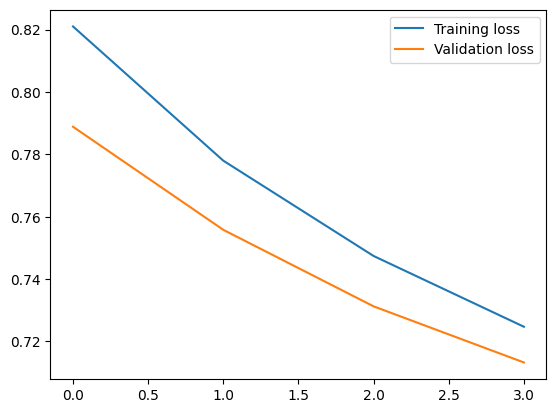

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

model.eval()
total_val_loss = 0
Y_pred_list = []
Y_true_list = []
with torch.no_grad():
    for data in test_loader:
        X_batch, Y_batch, speaker_ids = data
        X_batch, Y_batch , speaker_ids = X_batch.to(device), Y_batch.to(device).float(), speaker_ids.to(device)
        Y_pred = model(X_batch, speaker_ids)
        loss = criterion(Y_pred, Y_batch)
        total_val_loss += loss.item()

        Y_pred_binary = (Y_pred >= 0.5).int()
        Y_pred_list.extend(Y_pred_binary.cpu().numpy())
        Y_true_list.extend(Y_batch.cpu().numpy())

        
avg_val_loss = total_val_loss / len(test_loader)
val_loss.append(avg_val_loss)
print(f'Validation Loss: {avg_val_loss}')
Y_pred_np = np.hstack(Y_pred_list) 
Y_true_np = np.hstack(Y_true_list) 
print(classification_report(Y_true_np, Y_pred_np))

Validation Loss: 0.71326855301857
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88      1977
         1.0       0.00      0.00      0.00       523

    accuracy                           0.79      2500
   macro avg       0.40      0.50      0.44      2500
weighted avg       0.63      0.79      0.70      2500



In [ ]:
torch.save(model, "lstm_t2_model2.pth")
